In [24]:
#Graphing Notebook for network threat analysis. 

#This notebook will query elasticsearch pull suricata alerts from Security Onion 2 and add visual perpestive to the data

#Still need to figure out a better query structure, merging data frames together is not ideal

In [25]:
#Elasticsearch connector
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
import eland as ed
#Data manipulation
import pandas as pd
from pandas.io.json import json_normalize
import json
import re
import eland as ed
import numpy as np
import matplotlib.pyplot as plt
import math
import networkx as nx
import ipaddress
from collections import Counter
import networkx.algorithms.community as nxcom
from datetime import datetime
# Disable warnings"
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [26]:
es = Elasticsearch(['https://192.168.1.181:9200'], timeout=30, max_retries=10, retry_on_timeout=True,                  
ca_certs=False,verify_certs=False, http_auth=('jupyter','password'))

# defining the search statement to get all records in an index
searchContext = Search(using=es, index='*:so-*', doc_type='doc')
es.info()

ObjectApiResponse({'name': 'voodoo-onion', 'cluster_name': 'voodoo-onion', 'cluster_uuid': 'dP1VycCSTQ2EPeCVxQ25GA', 'version': {'number': '7.16.2', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '2b937c44140b6559905130a8650c64dbd0879cfb', 'build_date': '2021-12-18T19:42:46.604893745Z', 'build_snapshot': False, 'lucene_version': '8.10.1', 'minimum_wire_compatibility_version': '6.8.0', 'minimum_index_compatibility_version': '6.0.0-beta1'}, 'tagline': 'You Know, for Search'})

In [27]:
body_filter = '{"query":{"bool":{"must":[],"filter":[{"range":{"@timestamp":{"format":"strict_date_optional_time","gte":"2021-12-25","lte":"2022-01-02"}}}]}'

In [28]:
#Firewall 192.168.1.154

s1 = searchContext.query('query_string', query='(destination.port:443) AND NOT source.ip:(192.168.1.154 OR 192.168.1.220)')


In [29]:
pd.set_option("display.max_rows", 100)
pd.set_option("max_colwidth", 600)
pd.set_option("display.max_columns", None)


In [30]:
#data frame 1 for s1 which is search query 1
response = s1.execute()
df1 = pd.DataFrame(columns=['ts','source.ip','destination.ip','destination.port'])
if response.success():
    for d in s1[:10000]:
        try:
            df1 = df1.append({'ts' : d['@timestamp'], 'source.ip' : d['source']['ip'], 'destination.ip' : d['destination']['ip'], 'destination.port': d['destination']['port']}, ignore_index=True)
        except KeyError:
            pass       

display(df1)

df1.info()

,ts,source.ip,destination.ip,destination.port
0,2021-12-29T22:25:30.117Z,192.168.128.50,192.168.120.158,443
1,2021-12-29T22:23:29.880Z,192.168.128.50,192.168.120.158,443
2,2021-12-29T22:21:29.647Z,192.168.128.50,192.168.120.158,443
3,2021-12-29T22:19:29.627Z,192.168.128.50,192.168.120.158,443
4,2021-12-29T22:17:29.393Z,192.168.128.50,192.168.120.158,443
...,...,...,...,...
9995,2021-12-31T06:16:00.428Z,192.168.128.26,20.189.173.15,443
9996,2021-12-31T06:15:17.515Z,192.168.128.50,192.168.120.158,443
9997,2021-12-31T06:11:16.973Z,192.168.128.50,192.168.120.158,443
9998,2021-12-31T06:08:59.539Z,192.168.128.10,20.189.173.13,443


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ts                10000 non-null  object
 1   source.ip         10000 non-null  object
 2   destination.ip    10000 non-null  object
 3   destination.port  10000 non-null  object
dtypes: object(4)
memory usage: 312.6+ KB


In [31]:
s2 = searchContext.query('query_string', query='(destination.port:80 AND 53) AND NOT source.ip:(192.168.1.154 OR 192.168.1.220)')

In [32]:
#data frame 2 for s2 which is search query 2
response = s2.execute()
df2 = pd.DataFrame(columns=['ts','source.ip','destination.ip','destination.port'])
if response.success():
    for d in s2[:10000]:
        try:
            df2 = df2.append({'ts' : d['@timestamp'], 'source.ip' : d['source']['ip'], 'destination.ip' : d['destination']['ip'], 'destination.port': d['destination']['port']}, ignore_index=True)
        except KeyError:
            pass       

display(df2)

df2.info()

,ts,source.ip,destination.ip,destination.port
0,2021-12-30T22:53:59.996Z,192.168.128.50,192.168.120.158,80
1,2021-12-30T23:53:17.674Z,192.168.128.50,192.168.120.158,80
2,2021-12-30T21:53:56.547Z,192.168.128.50,192.168.120.158,80
3,2021-12-30T21:53:02.643Z,192.168.128.50,192.168.120.158,80
4,2021-12-30T22:53:08.969Z,192.168.128.50,192.168.120.158,80
...,...,...,...,...
250,2021-12-30T20:53:43.193Z,192.168.128.50,192.168.120.158,80
251,2021-12-30T20:53:33.637Z,192.168.128.50,192.168.120.158,80
252,2021-12-30T19:53:08.945Z,192.168.128.50,192.168.120.158,80
253,2021-12-30T22:53:30.138Z,192.168.128.50,192.168.120.158,80


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ts                255 non-null    object
 1   source.ip         255 non-null    object
 2   destination.ip    255 non-null    object
 3   destination.port  255 non-null    object
dtypes: object(4)
memory usage: 8.1+ KB


In [33]:
s3 = searchContext.query('query_string', query='event.dataset:alert AND network.transport:TCP')

In [34]:
#data frame 3 for s3 which is search query 3
response = s3.execute()
df3 = pd.DataFrame(columns=['ts','source.ip','destination.ip','destination.port', 'rule.severity', 'rule.gid'])
if response.success():
    for d in s3[:10000]:
        try:
            df3 = df3.append({'ts' : d['@timestamp'], 'source.ip' : d['source']['ip'], 'destination.ip' : d['destination']['ip'], 'destination.port': d['destination']['port'], 'severity': d['rule']['severity'], 'alertcount' : d['rule']['gid']}, ignore_index=True)
        except KeyError:
            pass       

display(df3)

df3.info()

,ts,source.ip,destination.ip,destination.port,rule.severity,rule.gid,alertcount,severity
0,2021-12-30T23:59:16.095Z,192.168.128.50,192.168.120.158,80,NaN,NaN,1.0,1.0
1,2021-12-30T23:58:26.591Z,192.168.128.50,192.168.120.158,80,NaN,NaN,1.0,1.0
2,2021-12-30T23:58:23.837Z,192.168.128.50,192.168.120.158,80,NaN,NaN,1.0,1.0
3,2021-12-30T23:57:26.948Z,192.168.128.50,192.168.120.158,80,NaN,NaN,1.0,1.0
4,2021-12-30T23:56:59.504Z,192.168.128.50,192.168.120.158,80,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...
3213,2022-01-01T00:06:04.200Z,192.168.128.50,192.168.120.158,80,NaN,NaN,1.0,1.0
3214,2022-01-01T00:04:47.959Z,192.168.128.50,192.168.120.158,80,NaN,NaN,1.0,1.0
3215,2022-01-01T00:02:51.687Z,192.168.128.50,192.168.120.158,80,NaN,NaN,1.0,1.0
3216,2022-01-01T00:01:18.396Z,192.168.128.50,192.168.120.158,80,NaN,NaN,1.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3218 entries, 0 to 3217
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ts                3218 non-null   object 
 1   source.ip         3218 non-null   object 
 2   destination.ip    3218 non-null   object 
 3   destination.port  3218 non-null   object 
 4   rule.severity     0 non-null      object 
 5   rule.gid          0 non-null      object 
 6   alertcount        3218 non-null   float64
 7   severity          3218 non-null   float64
dtypes: float64(2), object(6)
memory usage: 201.2+ KB


In [35]:
# assign field/column names to variables
f_timestamp = 'ts'
f_src_ip = 'source.ip'
f_dst_ip = 'destination.ip'
f_dst_port = 'destination.port'
rule_severity = 'rule.severity'
f_delimiter = '\t'

In [36]:
df1['ts'] = pd.to_datetime(df1['ts'],infer_datetime_format=True)
df1.head(10)

,ts,source.ip,destination.ip,destination.port
0,2021-12-29 22:25:30.117000+00:00,192.168.128.50,192.168.120.158,443
1,2021-12-29 22:23:29.880000+00:00,192.168.128.50,192.168.120.158,443
2,2021-12-29 22:21:29.647000+00:00,192.168.128.50,192.168.120.158,443
3,2021-12-29 22:19:29.627000+00:00,192.168.128.50,192.168.120.158,443
4,2021-12-29 22:17:29.393000+00:00,192.168.128.50,192.168.120.158,443
5,2021-12-29 22:15:29.032000+00:00,192.168.128.50,192.168.120.158,443
6,2021-12-29 22:13:28.874000+00:00,192.168.128.50,192.168.120.158,443
7,2021-12-29 22:11:28.594000+00:00,192.168.128.50,192.168.120.158,443
8,2021-12-29 22:09:28.216000+00:00,192.168.128.50,192.168.120.158,443
9,2021-12-29 22:07:27.924000+00:00,192.168.128.50,192.168.120.158,443


In [37]:
df2['ts'] = pd.to_datetime(df2['ts'],infer_datetime_format=True)
df2.head(10)

,ts,source.ip,destination.ip,destination.port
0,2021-12-30 22:53:59.996000+00:00,192.168.128.50,192.168.120.158,80
1,2021-12-30 23:53:17.674000+00:00,192.168.128.50,192.168.120.158,80
2,2021-12-30 21:53:56.547000+00:00,192.168.128.50,192.168.120.158,80
3,2021-12-30 21:53:02.643000+00:00,192.168.128.50,192.168.120.158,80
4,2021-12-30 22:53:08.969000+00:00,192.168.128.50,192.168.120.158,80
5,2021-12-30 20:53:45.940000+00:00,192.168.128.50,192.168.120.158,80
6,2021-12-30 19:53:49.912000+00:00,192.168.128.50,192.168.120.158,80
7,2022-12-31 22:10:53+00:00,192.168.128.50,192.168.120.158,80
8,2022-12-31 21:53:51+00:00,192.168.128.50,192.168.120.158,80
9,2022-12-31 21:11:53+00:00,192.168.128.50,192.168.120.158,80


In [38]:
df3['ts'] = pd.to_datetime(df3['ts'],infer_datetime_format=True)
df3.head(10)

,ts,source.ip,destination.ip,destination.port,rule.severity,rule.gid,alertcount,severity
0,2021-12-30 23:59:16.095000+00:00,192.168.128.50,192.168.120.158,80,NaN,NaN,1.0,1.0
1,2021-12-30 23:58:26.591000+00:00,192.168.128.50,192.168.120.158,80,NaN,NaN,1.0,1.0
2,2021-12-30 23:58:23.837000+00:00,192.168.128.50,192.168.120.158,80,NaN,NaN,1.0,1.0
3,2021-12-30 23:57:26.948000+00:00,192.168.128.50,192.168.120.158,80,NaN,NaN,1.0,1.0
4,2021-12-30 23:56:59.504000+00:00,192.168.128.50,192.168.120.158,80,NaN,NaN,1.0,1.0
5,2021-12-30 23:56:30.531000+00:00,192.168.128.50,192.168.120.158,80,NaN,NaN,1.0,1.0
6,2021-12-30 23:55:32.745000+00:00,192.168.128.50,192.168.120.158,80,NaN,NaN,1.0,1.0
7,2021-12-30 23:55:31.068000+00:00,192.168.128.50,192.168.120.158,80,NaN,NaN,1.0,1.0
8,2021-12-30 23:54:36.846000+00:00,192.168.128.50,192.168.120.158,80,NaN,NaN,1.0,1.0
9,2021-12-30 23:53:47.235000+00:00,192.168.128.50,192.168.120.158,80,NaN,NaN,1.0,1.0


In [39]:
# Merge the two to create our final dataframe for graphing
dfg = pd.concat([df1, df2, df3], ignore_index=True)
print(dfg.head(5))
print(dfg.tail(5))

                                ts       source.ip   destination.ip  \
0 2021-12-29 22:25:30.117000+00:00  192.168.128.50  192.168.120.158   
1 2021-12-29 22:23:29.880000+00:00  192.168.128.50  192.168.120.158   
2 2021-12-29 22:21:29.647000+00:00  192.168.128.50  192.168.120.158   
3 2021-12-29 22:19:29.627000+00:00  192.168.128.50  192.168.120.158   
4 2021-12-29 22:17:29.393000+00:00  192.168.128.50  192.168.120.158   

  destination.port rule.severity rule.gid  alertcount  severity  
0              443           NaN      NaN         NaN       NaN  
1              443           NaN      NaN         NaN       NaN  
2              443           NaN      NaN         NaN       NaN  
3              443           NaN      NaN         NaN       NaN  
4              443           NaN      NaN         NaN       NaN  
                                    ts       source.ip   destination.ip  \
13468 2022-01-01 00:06:04.200000+00:00  192.168.128.50  192.168.120.158   
13469 2022-01-01 00:04:47.9

In [40]:
## Do some data cleaning and prep
# Fill NaN data
dfg = dfg.fillna(0)
print(dfg.head(5))
print(dfg.tail(5))

                                ts       source.ip   destination.ip  \
0 2021-12-29 22:25:30.117000+00:00  192.168.128.50  192.168.120.158   
1 2021-12-29 22:23:29.880000+00:00  192.168.128.50  192.168.120.158   
2 2021-12-29 22:21:29.647000+00:00  192.168.128.50  192.168.120.158   
3 2021-12-29 22:19:29.627000+00:00  192.168.128.50  192.168.120.158   
4 2021-12-29 22:17:29.393000+00:00  192.168.128.50  192.168.120.158   

  destination.port  rule.severity  rule.gid  alertcount  severity  
0              443              0         0         0.0       0.0  
1              443              0         0         0.0       0.0  
2              443              0         0         0.0       0.0  
3              443              0         0         0.0       0.0  
4              443              0         0         0.0       0.0  
                                    ts       source.ip   destination.ip  \
13468 2022-01-01 00:06:04.200000+00:00  192.168.128.50  192.168.120.158   
13469 2022-01-0

In [41]:
columns_to_filter = [f_timestamp, f_src_ip, f_dst_ip, f_dst_port, rule_severity,]
columns_to_groupby = [f_src_ip, f_dst_ip, f_dst_port,]
# columns to display after the analysis
columns_to_display = ['tsScore','conn_count',f_src_ip,f_dst_ip,f_dst_port,rule_severity,'deltas']

In [42]:
# If you have a large dateset, using groupby and aggregate(list) might be slow. Consider using dask
dfg = dfg.groupby(columns_to_groupby).agg(list)
dfg.head(5)

ts  \
source.ip      destination.ip destination.port                                                                                                                                                                                                                                                                                                                                                                                                                             
13.107.4.50    192.168.1.154  42988                                                                                                                                                                                                                                                                                                                                                                                                   [2022-01-02 02:16:40.952000+00:00]   
167.248.133.30 192.168.1.154  1194                                                                                                                                                                                                                                                                                                                                                                                                    [2022-01-01 01:26:56.432000+00:00]   
192.168.1.149  208.91.0.89    443                                                                                                                                                                                                                                                                                                                                 [2022-01-02 18:13:55.750000+00:00, 2022-01-02 18:10:35.848000+00:00, 2022-01-02 18:14:05.657000+00:00]   
192.168.1.154  104.100.149.44 80                                                  [2022-01-01 07:36:45.675000+00:00, 2022-01-01 07:36:45.382000+00:00, 2022-01-01 07:36:45.052000+00:00, 2022-01-01 07:36:44.785000+00:00, 2022-01-01 07:36:44.505000+00:00, 2022-01-01 07:36:44.206000+00:00, 2022-01-01 07:36:43.930000+00:00, 2022-01-01 07:36:43.655000+00:00, 2022-01-01 07:36:43.348000+00:00, 2022-01-01 07:36:43.076000+00:00, 2022-01-01 07:36:42.424000+00:00]   
               168.63.250.82  80                [2022-01-01 07:36:45.912000+00:00, 2022-01-01 07:36:45.617000+00:00, 2022-01-01 07:36:45.287000+00:00, 2022-01-01 07:36:45.020000+00:00, 2022-01-01 07:36:44.747000+00:00, 2022-01-01 07:36:44.472000+00:00, 2022-01-01 07:36:44.171000+00:00, 2022-01-01 07:36:43.891000+00:00, 2022-01-01 07:36:43.585000+00:00, 2022-01-01 07:36:43.316000+00:00, 2022-01-01 07:36:43.036000+00:00, 2022-01-01 07:36:43.036000+00:00]   

                                                                       rule.severity  \
source.ip      destination.ip destination.port                                         
13.107.4.50    192.168.1.154  42988                                              [0]   
167.248.133.30 192.168.1.154  1194                                               [0]   
192.168.1.149  208.91.0.89    443                                          [0, 0, 0]   
192.168.1.154  104.100.149.44 80                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
               168.63.250.82  80                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

                                                                            rule.gid  \
source.ip      destination.ip destination.port                                         
13.107.4.50    192.168.1.154  42988                                              [0]   
167.248.133.30 192.168.1.154  1194                                               [0]   
192.168.1.149  208.91.0.89    443                                          [0, 0, 0]   
192.168.1.154  104.100.149.44 80                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
               168.63.250.82  80                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   


In [43]:
dfg.reset_index(inplace=True)
dfg.head(5)

,source.ip,destination.ip,destination.port,ts,rule.severity,rule.gid,alertcount,severity
0,13.107.4.50,192.168.1.154,42988,[2022-01-02 02:16:40.952000+00:00],[0],[0],[1.0],[3.0]
1,167.248.133.30,192.168.1.154,1194,[2022-01-01 01:26:56.432000+00:00],[0],[0],[1.0],[2.0]
2,192.168.1.149,208.91.0.89,443,"[2022-01-02 18:13:55.750000+00:00, 2022-01-02 18:10:35.848000+00:00, 2022-01-02 18:14:05.657000+00:00]","[0, 0, 0]","[0, 0, 0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
3,192.168.1.154,104.100.149.44,80,"[2022-01-01 07:36:45.675000+00:00, 2022-01-01 07:36:45.382000+00:00, 2022-01-01 07:36:45.052000+00:00, 2022-01-01 07:36:44.785000+00:00, 2022-01-01 07:36:44.505000+00:00, 2022-01-01 07:36:44.206000+00:00, 2022-01-01 07:36:43.930000+00:00, 2022-01-01 07:36:43.655000+00:00, 2022-01-01 07:36:43.348000+00:00, 2022-01-01 07:36:43.076000+00:00, 2022-01-01 07:36:42.424000+00:00]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]"
4,192.168.1.154,168.63.250.82,80,"[2022-01-01 07:36:45.912000+00:00, 2022-01-01 07:36:45.617000+00:00, 2022-01-01 07:36:45.287000+00:00, 2022-01-01 07:36:45.020000+00:00, 2022-01-01 07:36:44.747000+00:00, 2022-01-01 07:36:44.472000+00:00, 2022-01-01 07:36:44.171000+00:00, 2022-01-01 07:36:43.891000+00:00, 2022-01-01 07:36:43.585000+00:00, 2022-01-01 07:36:43.316000+00:00, 2022-01-01 07:36:43.036000+00:00, 2022-01-01 07:36:43.036000+00:00]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]"


In [44]:
# create a new column 'conn_count', and for each row in the 'ts' column, apply a function and assign the returned value to the 'conn_count' column
dfg['conn_count'] = dfg[f_timestamp].apply(lambda x: len(x))
dfg.head(2)

,source.ip,destination.ip,destination.port,ts,rule.severity,rule.gid,alertcount,severity,conn_count
0,13.107.4.50,192.168.1.154,42988,[2022-01-02 02:16:40.952000+00:00],[0],[0],[1.0],[3.0],1
1,167.248.133.30,192.168.1.154,1194,[2022-01-01 01:26:56.432000+00:00],[0],[0],[1.0],[2.0],1


In [45]:
#Filter out traffic where the connection count is quite small
dfg = dfg.loc[dfg['conn_count'] > 10]
dfg.shape

(120, 9)

In [46]:
# create a new column 'alertcount', and for each row in the 'ts' column, apply a function and assign the returned value to the 'conn_count' column
dfg['alertcount'] = dfg['alertcount'].apply(lambda x: len(x))
dfg.head(2)

,source.ip,destination.ip,destination.port,ts,rule.severity,rule.gid,alertcount,severity,conn_count
3,192.168.1.154,104.100.149.44,80,"[2022-01-01 07:36:45.675000+00:00, 2022-01-01 07:36:45.382000+00:00, 2022-01-01 07:36:45.052000+00:00, 2022-01-01 07:36:44.785000+00:00, 2022-01-01 07:36:44.505000+00:00, 2022-01-01 07:36:44.206000+00:00, 2022-01-01 07:36:43.930000+00:00, 2022-01-01 07:36:43.655000+00:00, 2022-01-01 07:36:43.348000+00:00, 2022-01-01 07:36:43.076000+00:00, 2022-01-01 07:36:42.424000+00:00]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",11,"[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]",11
4,192.168.1.154,168.63.250.82,80,"[2022-01-01 07:36:45.912000+00:00, 2022-01-01 07:36:45.617000+00:00, 2022-01-01 07:36:45.287000+00:00, 2022-01-01 07:36:45.020000+00:00, 2022-01-01 07:36:44.747000+00:00, 2022-01-01 07:36:44.472000+00:00, 2022-01-01 07:36:44.171000+00:00, 2022-01-01 07:36:43.891000+00:00, 2022-01-01 07:36:43.585000+00:00, 2022-01-01 07:36:43.316000+00:00, 2022-01-01 07:36:43.036000+00:00, 2022-01-01 07:36:43.036000+00:00]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",12,"[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]",12


In [47]:
# create a new column 'alertcount', and for each row in the 'ts' column, apply a function and assign the returned value to the 'conn_count' column
dfg['severity'] = dfg['severity'].apply(lambda x: len(x))
dfg.head(2)

,source.ip,destination.ip,destination.port,ts,rule.severity,rule.gid,alertcount,severity,conn_count
3,192.168.1.154,104.100.149.44,80,"[2022-01-01 07:36:45.675000+00:00, 2022-01-01 07:36:45.382000+00:00, 2022-01-01 07:36:45.052000+00:00, 2022-01-01 07:36:44.785000+00:00, 2022-01-01 07:36:44.505000+00:00, 2022-01-01 07:36:44.206000+00:00, 2022-01-01 07:36:43.930000+00:00, 2022-01-01 07:36:43.655000+00:00, 2022-01-01 07:36:43.348000+00:00, 2022-01-01 07:36:43.076000+00:00, 2022-01-01 07:36:42.424000+00:00]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",11,11,11
4,192.168.1.154,168.63.250.82,80,"[2022-01-01 07:36:45.912000+00:00, 2022-01-01 07:36:45.617000+00:00, 2022-01-01 07:36:45.287000+00:00, 2022-01-01 07:36:45.020000+00:00, 2022-01-01 07:36:44.747000+00:00, 2022-01-01 07:36:44.472000+00:00, 2022-01-01 07:36:44.171000+00:00, 2022-01-01 07:36:43.891000+00:00, 2022-01-01 07:36:43.585000+00:00, 2022-01-01 07:36:43.316000+00:00, 2022-01-01 07:36:43.036000+00:00, 2022-01-01 07:36:43.036000+00:00]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",12,12,12


In [48]:
# Recast float types to int
dfg["conn_count"] = dfg["conn_count"].astype("int64")
dfg["severity"] = dfg["severity"].astype("int64")
dfg["alertcount"] = dfg["alertcount"].astype("int64")
dfg["destination.port"] = dfg["destination.port"].astype("int64")

In [49]:
# Calculate the weights based off of the count of unique Suricata alerts
maxalertcount=dfg["alertcount"].max()
maxconncount=dfg["conn_count"].max()
dfg["alertweight"] = dfg.apply(lambda x: 10/maxalertcount*x.alertcount+0.1, axis=1)
dfg["connweight"] = dfg.apply(lambda x: 10/maxconncount*x.conn_count+0.1, axis=1)

In [50]:
# Show the min/max values for both calculated weights
print(dfg.alertweight.min())
print(dfg.alertweight.max())
print(dfg.connweight.min())
print(dfg.connweight.max())
# Show first and last 5 records
print(dfg.head(5))
print(dfg.tail(5))

0.134667507091081
10.1
0.134667507091081
10.1
         source.ip  destination.ip  destination.port  \
3    192.168.1.154  104.100.149.44                80   
4    192.168.1.154   168.63.250.82                80   
5    192.168.1.154  184.86.191.118                80   
6    192.168.1.154   52.188.50.245                80   
59  192.168.128.10   20.189.173.14               443   

                                                                                                                                                                                                                                                                                                                                                                                                                                                            ts  \
3                                                                       [2022-01-01 07:36:45.675000+00:00, 2022-01-01 07:36:45.382000+00:00, 2022-01-01 07:36:45.052000

In [51]:
# Create graphs
# Create our graph from our pandas dataframe
G = nx.from_pandas_edgelist(dfg, source="source.ip", target="destination.ip", edge_key="destination.port", edge_attr=True, create_using=nx.MultiDiGraph())
G2 = nx.from_pandas_edgelist(dfg, source="source.ip", target="destination.ip", edge_attr=True, create_using=nx.Graph())

In [52]:
# add our node attributes
# List of desired source attributes:
src_attributes = [ "alertcount","severity", "alertweight", "connweight"]

# Iterate over df rows and set source node attributes:
for index, row in dfg.iterrows():
    src_attr_dict = {k: row.to_dict()[k] for k in src_attributes}    
    G.nodes[row["source.ip"]].update(src_attr_dict)
    G.nodes[row["destination.ip"]].update(src_attr_dict)

In [53]:
# Check how many nodes the graph contains to set attributes for figure size
n = len(G.nodes)
if n > 50:
    largegraph=True
    fig_size = (50,40)
    print("Large Graph: %s , using large graph functions" % n)
if n <= 500 > 999:
    fig_size = (40,30)
    largegraph=False
    print("Small Graph: %s figsize: %s" % (n, fig_size))
if n <= 250  > 499 :
    fig_size = (30,20)
    largegraph=False
    print("Small Graph: %s figsize: %s" % (n, fig_size))
if n < 100 > 0:
    fig_size = (18,15)
    largegraph=False
    print("Small Graph: %s figsize: %s" % (n, fig_size))

Large Graph: 88 , using large graph functions
Small Graph: 88 figsize: (18, 15)


In [54]:
print("Graph analysis\n")
print("Multi-edge directed Graph\n")
print("Number of nodes: %s\t" % len(G.nodes))
print("Number of edges: %s\n" % len(G.edges))
print("Graph density: %s\n" % nx.density(G))
print("Graph is directed: %s\n" % G.is_directed())
print("Graph is weighted: %s\n" % nx.is_weighted(G))
print("Undirected Graph\n")
print("Transitivity: %s" % nx.transitivity(G2))
print("Average clustering coefficient: %s" % nx.average_clustering(G2))
communities = sorted(nxcom.greedy_modularity_communities(G2), key=len, reverse=True)
print("Greedy Modularity Communities: %s" % len(communities))

Graph analysis

Multi-edge directed Graph

Number of nodes: 88	
Number of edges: 118

Graph density: 0.01541274817136886

Graph is directed: True

Graph is weighted: False

Undirected Graph

Transitivity: 0
Average clustering coefficient: 0.0
Greedy Modularity Communities: 7


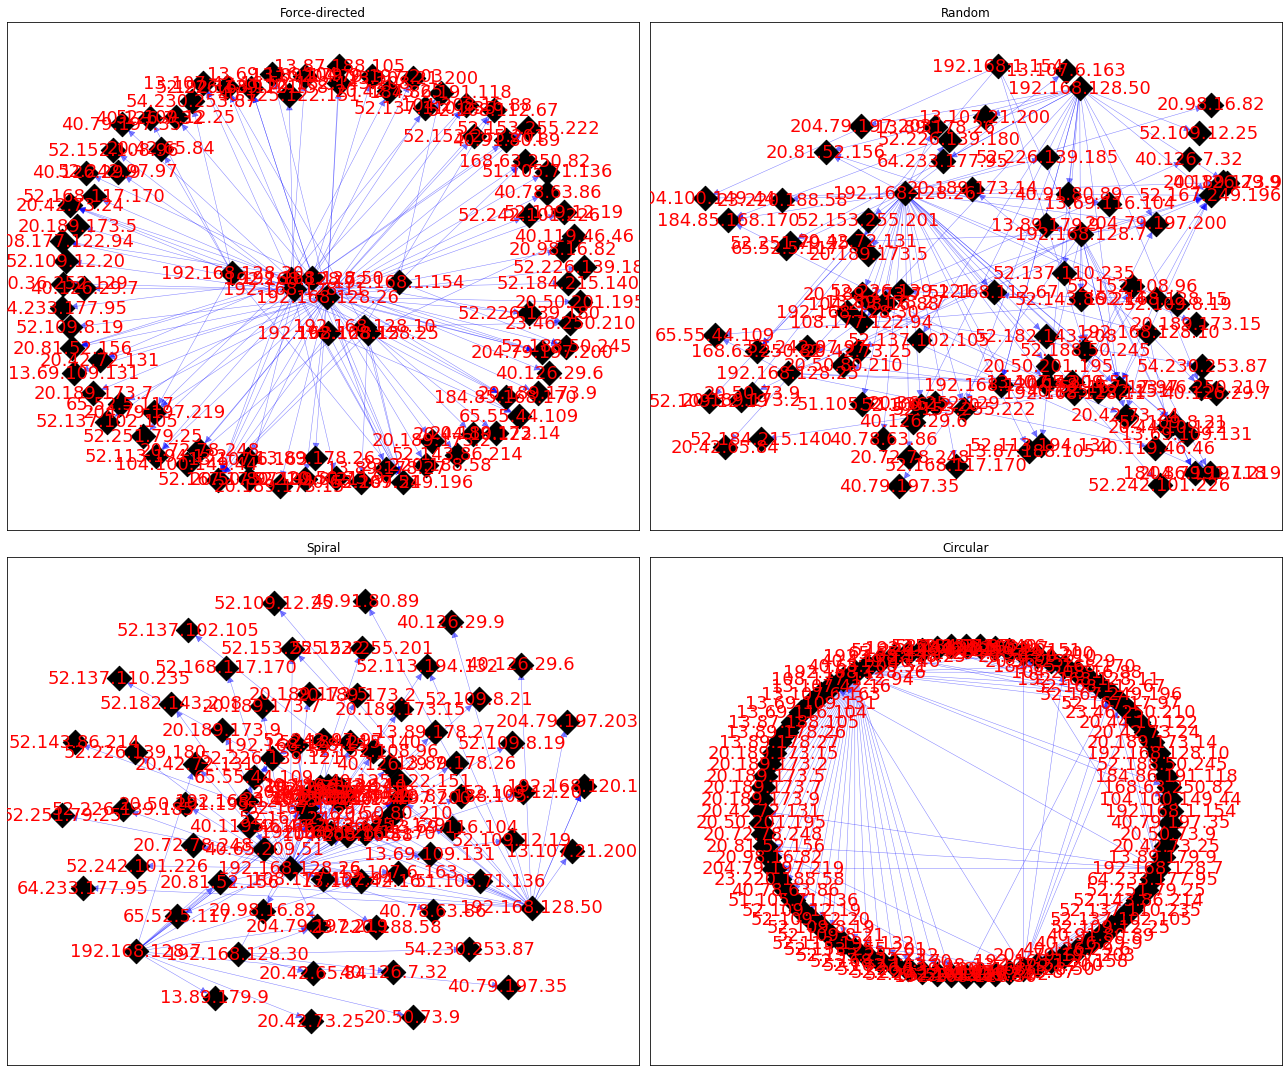

In [55]:
# Draw our graph
#Define our Graph Plot Layouts
layouts = (nx.spring_layout, nx.random_layout, nx.spiral_layout, nx.circular_layout)
title = ("Force-directed", "Random", "Spiral", "Circular")
## Create our Plots
# Create 4 subplots with the figure size based on graph size
_, plot = plt.subplots(2, 2, figsize=fig_size)
subplots = plot.reshape(1, 4)[0]
# Draw a plot for each layout
for plot, layout, title in zip(subplots, layouts, title):
    pos = layout(G)
    nx.draw_networkx_edges(G, pos, ax=plot, width=0.5, style="solid", edge_color="blue", alpha=0.5, arrows=True, arrowsize=15, arrowstyle="-|>")
    nx.draw_networkx_nodes(G, pos, ax=plot, node_color="black", node_shape="D")
    # Draw labels
    nx.draw_networkx_labels(G, pos, ax=plot, font_color="red", font_size=18)
    plot.set_title(title)
# Draw with tight layout https://matplotlib.org/tutorials/intermediate/tight_layout_guide.html
plt.gca().margins(0.20, 0.20)
plt.tight_layout()
plt.show(block=False)

In [56]:
## Nodes and Edge contextualization
# Create lists for  private, reserved or public IP address nodes
private_ips = [ip for ip in G.nodes if ipaddress.ip_address(ip).is_private]
global_ips = [ip for ip in list(G.nodes) if ipaddress.ip_address(ip).is_global]
reserved_ips = [ip for ip in G.nodes if ipaddress.ip_address(ip).is_reserved]

# create node label lists for each severity
node_labels_sev3 = dict([(u, u) for (u, v) in G.nodes(data=True) if v["severity"] == 3])
node_labels_sev2 = dict([(u, u) for (u, v) in G.nodes(data=True) if v["severity"] == 2])
node_labels_sev1 = dict([(u, u) for (u, v) in G.nodes(data=True) if v["severity"] == 1])
node_labels_sev0 = dict([(u, u) for (u, v) in G.nodes(data=True) if v["connweight"] > 0.5])

# create weights for node sizing
node_weights = nx.get_node_attributes(G, "alertweight")

In [57]:

# Create lists containing incoming and outgoing edges by Surcicata alert severity
in_sev3 = [(u, v) for (u, v, d) in G.in_edges(data=True) if d["severity"] == 3]
out_sev3 = [(u, v) for (u, v, d) in G.out_edges(data=True) if d["severity"] == 3]
in_sev2 = [(u, v) for (u, v, d) in G.in_edges(data=True) if d["severity"] == 2]
out_sev2 = [(u, v) for (u, v, d) in G.out_edges(data=True) if d["severity"] == 2]
in_sev1 = [(u, v) for (u, v, d) in G.in_edges(data=True) if d["severity"] == 1]
out_sev1 = [(u, v) for (u, v, d) in G.out_edges(data=True) if d["severity"] == 1]
in_sev0 = [(u, v) for (u, v, d) in G.in_edges(data=True) if d["severity"] == 0]
out_sev0 = [(u, v) for (u, v, d) in G.out_edges(data=True) if d["severity"] == 0]


# Get edge weights for in and out edges by alert severity
edge_weights_conn_in = [d["connweight"] for s,t,d in G.in_edges(data=True) if d["severity"] == 0]
edge_weights_conn_out = [d["connweight"] for s,t,d in G.out_edges(data=True) if d["severity"] == 0]
edge_weights_alerts_sev3_in = [d["alertweight"] for s,t,d in G.in_edges(data=True) if d["severity"] == 3]
edge_weights_alerts_sev3_out = [d["alertweight"] for s,t,d in G.out_edges(data=True) if d["severity"] == 3]
edge_weights_alerts_sev2_in = [d["alertweight"] for s,t,d in G.in_edges(data=True) if d["severity"] == 2]
edge_weights_alerts_sev2_out = [d["alertweight"] for s,t,d in G.out_edges(data=True) if d["severity"] == 2]
edge_weights_alerts_sev1_in = [d["alertweight"] for s,t,d in G.in_edges(data=True) if d["severity"] == 1]
edge_weights_alerts_sev1_out = [d["alertweight"] for s,t,d in G.out_edges(data=True) if d["severity"] == 1]

# Get edge labels and create dictionary of edges by suricata alert severities
edge_labels_sev1_in = dict([((u,v,),d["alertcount"]) for (u, v, d) in G.in_edges(data=True) if d["severity"] == 1])
edge_labels_sev1_out = dict([((u,v,),d["alertcount"]) for (u, v, d) in G.out_edges(data=True) if d["severity"] == 1])
edge_labels_sev2_in = dict([((u,v,),d["alertcount"]) for (u, v, d) in G.in_edges(data=True) if d["severity"] == 2])
edge_labels_sev2_out = dict([((u,v,),d["alertcount"]) for (u, v, d) in G.out_edges(data=True) if d["severity"] == 2])
edge_labels_sev3_in = dict([((u,v,),d["alertcount"]) for (u, v, d) in G.in_edges(data=True) if d["severity"] == 3])
edge_labels_sev3_out = dict([((u,v,),d["alertcount"]) for (u, v, d) in G.out_edges(data=True) if d["severity"] == 3])


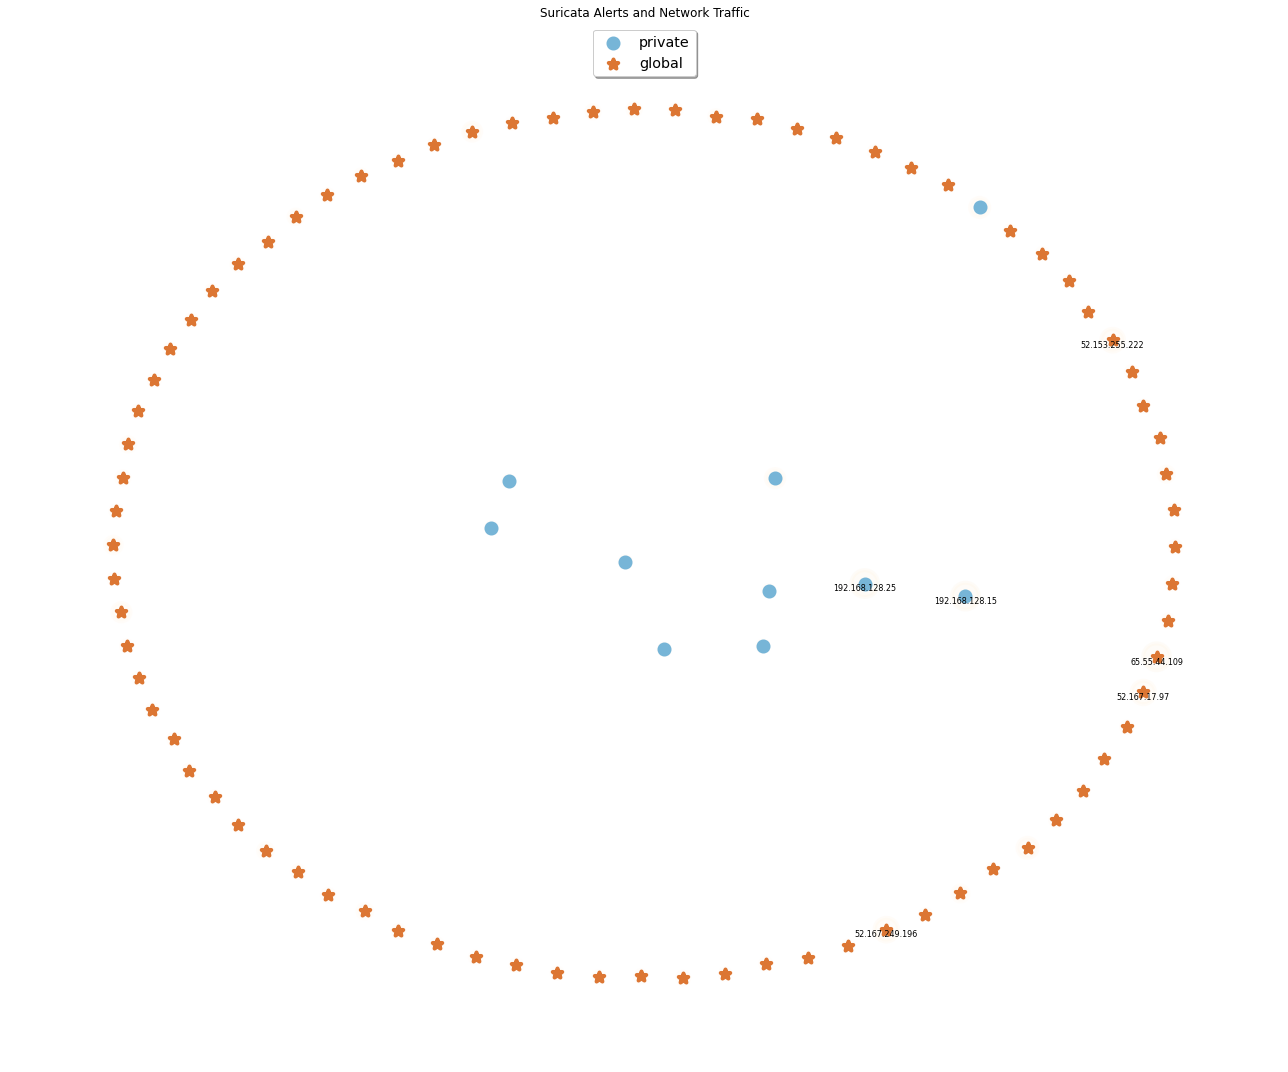

In [58]:

## Draw our graph
# Adjust the size of the figure to be plotted
plt.figure(figsize=fig_size)
# Set title
ax = plt.gca()
ax.set_title("Suricata Alerts and Network Traffic")
# Create the positioning for our graph using the Spring Layout.
# We're using "alertweight" for the layout weight, but you could also try "connweight", or even "severity" here
# k controls the distance between the nodes and varies between 0 and 1
# iterations is the number of times simulated annealing is run
# default k=0.1 and iterations=50
pos = nx.spring_layout(G, scale=1.2, k=0.9, iterations=1000, weight='alertweight')

# Draw Zeek connection edges (severity 0), color edges on a blue scale by the connectin weight (based on the count of unique
# connections) for incoming and outgoing connections
nx.draw_networkx_edges(G, 
                       pos, 
                       width=10, 
                       style='solid',
                       edgelist=in_sev0,
                       edge_color=edge_weights_conn_in,
                       edge_cmap=plt.cm.Blues,
                       edge_vmin=0.1,
                       edge_vmax=10.1, 
                       alpha=0.6, 
                       arrows=True, 
                       min_source_margin=0.2,
                       min_target_margin=0.2)
nx.draw_networkx_edges(G, 
                       pos, 
                       width=10, 
                       style='solid',
                       edgelist=out_sev0,
                       edge_color=edge_weights_conn_out,
                       edge_cmap=plt.cm.Blues,
                       edge_vmin=0.1,
                       edge_vmax=10.1, 
                       alpha=0.6, 
                       arrows=True, 
                       min_source_margin=0.2,
                       min_target_margin=0.2)
# Draw all nodes based on our node_weights (based on alertweight). This will color nodes on a cool/warm scale,
# and also draw the node size based on the weight. We draw the nodes transparently, so that we can draw the node type on top
nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=node_weights.keys(),
                       node_color=list(node_weights.values()),
                       cmap=plt.cm.OrRd,
                       vmin=0.1,
                       vmax=10.1,
                       node_shape='o',
                       linewidths=4,
                       alpha=0.2,
                       node_size=[v * 900 for v in node_weights.values()])


# Draw the type of node on top of each node, for global, private and reserved IP's
nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=private_ips,
                       node_color='#77B5D7', 
                       node_shape='o',
                       linewidths=4,
                       alpha=1,
                       label='private',
                       node_size=100)
nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=global_ips, 
                       node_color='#DC7633', 
                       node_shape='*',  
                       linewidths=4,
                       alpha=1,
                       label='global',
                       node_size=100)

nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=reserved_ips, 
                       node_color='#C0392B', 
                       node_shape='P',  
                       linewidths=4,
                       alpha=1,
                       label='reserved',
                       node_size=100)

# Draw the corresponding labels for each node
# For Severity 1
nx.draw_networkx_labels(G, 
                        pos,
                        font_color='black',
                        verticalalignment='top',
                        labels=node_labels_sev1,
                        font_size=10)
# For Severity 2
nx.draw_networkx_labels(G, 
                        pos,
                        font_color='black',
                        verticalalignment='top',
                        labels=node_labels_sev2,
                        font_size=12)
# For Severity 3
nx.draw_networkx_labels(G, 
                        pos,
                        font_color='black',
                        verticalalignment='top',
                        labels=node_labels_sev3,
                        font_size=15)
# For connections with a connection weight of over 0.5
nx.draw_networkx_labels(G, 
                        pos,
                        font_color='black',
                        verticalalignment='top',
                        labels=node_labels_sev0,
                        font_size=8)

# Draw our edges and edge labels for each severity
# Red = 3
# Yellow = 2
# Green =1
# For the edge labels we show the count of Suricata alerts
nx.draw_networkx_edges(G, 
                       pos, 
                       edgelist=in_sev1, 
                       width=2, 
                       style='solid', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='#52BE80',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       label='sev1',
                       min_source_margin=3.0,
                       min_target_margin=3.0)

nx.draw_networkx_edge_labels(G,
                             pos,
                             edge_labels=edge_labels_sev1_in,
                             label_pos=0.9,
                             font_color='#229954',
                             font_size=8)
nx.draw_networkx_edges(G, 
                       pos, 
                       edgelist=out_sev1, 
                       width=2, 
                       style='dashed', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='#52BE80',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       min_source_margin=3.0,
                       min_target_margin=3.0)

nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels=edge_labels_sev1_out, 
                             label_pos=0.9, 
                             font_color='#229954', 
                             font_size=8)

nx.draw_networkx_edges(G, 
                       pos, 
                       edgelist=in_sev2, 
                       width=1.5, 
                       style='solid', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='#F5B041',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       label='sev2',
                       min_source_margin=3.0,
                       min_target_margin=3.0)

nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels=edge_labels_sev2_in, 
                             label_pos=0.3, 
                             font_color='#F39C12', 
                             font_size=8)
nx.draw_networkx_edges(G, 
                       pos, 
                       edgelist=out_sev2, 
                       width=1.5, 
                       style='dashed', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='#F5B041',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       min_source_margin=3.0,
                       min_target_margin=3.0)

nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels=edge_labels_sev2_out, 
                             label_pos=0.3, 
                             font_color='#F39C12', 
                             font_size=8)

nx.draw_networkx_edges(G, 
                       pos,
                       edgelist=in_sev3, 
                       width=1, 
                       style='solid',
                       connectionstyle='arc3,rad=0.1',
                       edge_color='#E74C3C',
                       alpha=0.8, 
                       arrows=True,
                       arrowsize=20,
                       label='sev3',
                       min_source_margin=5.0,
                       min_target_margin=5.0)

nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels=edge_labels_sev3_in, 
                             label_pos=0.1, 
                             font_color='#E74C3C', 
                             font_weight="bold", 
                             font_size=8)

nx.draw_networkx_edges(G, 
                       pos,
                       edgelist=out_sev3, 
                       width=1, 
                       style='dotted',
                       connectionstyle='arc3,rad=0.1',
                       edge_color='#E74C3C',
                       alpha=0.8, 
                       arrows=True,
                       arrowsize=20,
                       min_source_margin=5.0,
                       min_target_margin=5.0)

nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels=edge_labels_sev3_out, 
                             label_pos=0.1, 
                             font_color='#E74C3C',
                             font_weight="bold", 
                             font_size=8)

# Draw without box lines
plt.box(on=None)
# Draw legend
plt.legend(loc='upper center', shadow=True, fontsize='x-large')
# Set margins
plt.gca().margins(0.1, 0.1)
# Set tight layout
plt.tight_layout()
plt.show()